In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
#IMPORT TRAIN AND TEST SETS
train_features = pd.read_csv('./data/derived/feature_selection/training_data.csv', index_col=0)
test_features = pd.read_csv('./data/derived/feature_selection/test_data.csv', index_col=0)

features = [
    'genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig',
    'gag_lrtt', 'gag_maf3c', 'gag_ambig',
    'gp41_maf3c', 'gp41_ambig', 
    'gp120_lrtt', 'gp120_ambig'
]
features2 = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig', #best
             'gag_lrtt', 'gag_maf12c' ,'gag_maf3c', 'gag_ambig',
             'gp120_lrtt', 'gp120_maf12c', 'gp120_tips',
             'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig', 
             'gp41_maf12c' ,'gp41_maf3c', 
]
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                    'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 'gp41_ambig'
]

In [36]:
# Transform TSI_days using the square root
train_features['sqrt_TSI_days'] = np.sqrt(train_features['TSI_days'])
test_features['sqrt_TSI_days'] = np.sqrt(test_features['TSI_days'])

# Convert TSI_days to TSI_years
train_features['TSI_years'] = train_features['TSI_days'] / 365
test_features['TSI_years'] = test_features['TSI_days'] / 365

# Transform TSI_years using the square root
train_features['sqrt_TSI_years'] = np.sqrt(train_features['TSI_years'])
test_features['sqrt_TSI_years'] = np.sqrt(test_features['TSI_years'])

'''# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['sqrt_TSI_days']
X_test = test_features[features_derived]
y_test = test_features['sqrt_TSI_days']'''

# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['sqrt_TSI_years']
X_test = test_features[features_derived]
y_test = test_features['sqrt_TSI_years']

# Train a random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42,  
                              bootstrap= True,
                              max_depth= 10,
                              max_features= 'sqrt',
                              min_samples_leaf= 1,
                              min_samples_split= 10,
                              )
model.fit(X_train, y_train)

# Make predictions

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.26979099769010256
R-squared: 0.6275760877611523


# CROSS VAL FOR TUNING HYPER PARAMETERS

In [ ]:
# Transform TSI_days using the square root
train_features['sqrt_TSI_days'] = np.sqrt(train_features['TSI_days'])
test_features['sqrt_TSI_days'] = np.sqrt(test_features['TSI_days'])

# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['sqrt_TSI_days']
X_test = test_features[features_derived]
y_test = test_features['sqrt_TSI_days']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]  # Ensure subsampling without replacement
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

In [29]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 98.51069476344657
R-squared: 0.6274362284871356


# PLOT RESULTS W/TUNED HYPERPARAMETERS

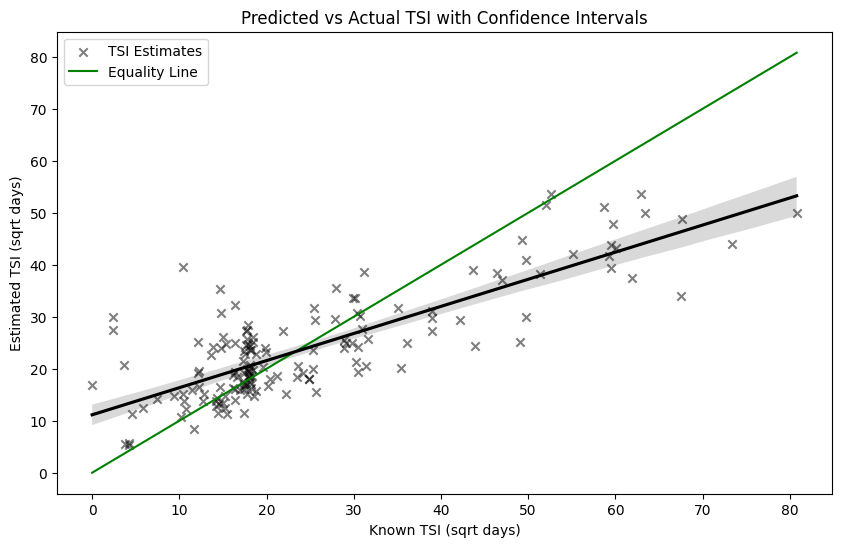

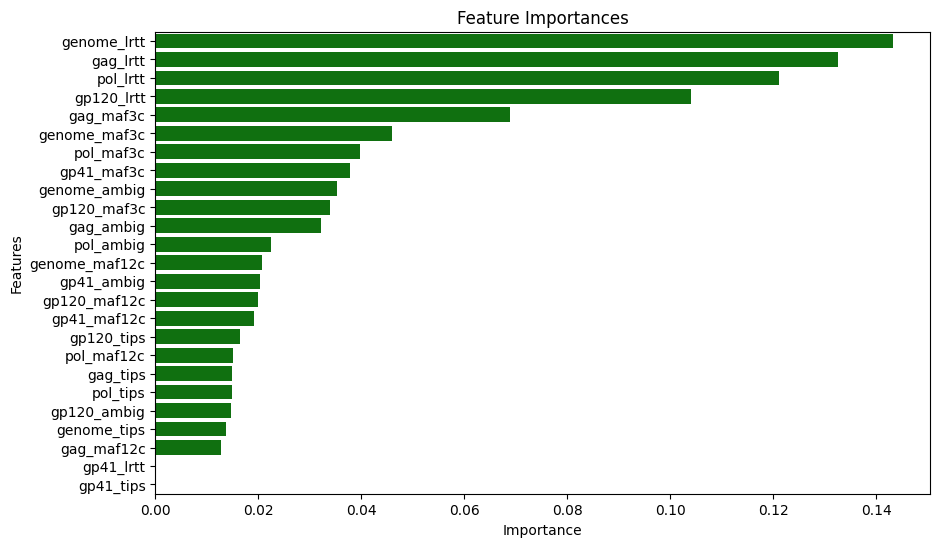

In [35]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='TSI Estimates', color='black', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g-', label='Equality Line')
sns.regplot(x=y_test, y=y_pred, scatter=False, ci=95, color='black')
plt.xlabel('Known TSI (sqrt days)')
plt.ylabel('Estimated TSI (sqrt days)')
plt.title('Predicted vs Actual TSI with Confidence Intervals')
plt.legend()
plt.savefig('./outputs/predictions/predicted_tsi_days.png')
plt.show()

# Plot feature importances
feature_importances = model.feature_importances_
features = features_derived

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'Feature': features_derived,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color = 'green')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

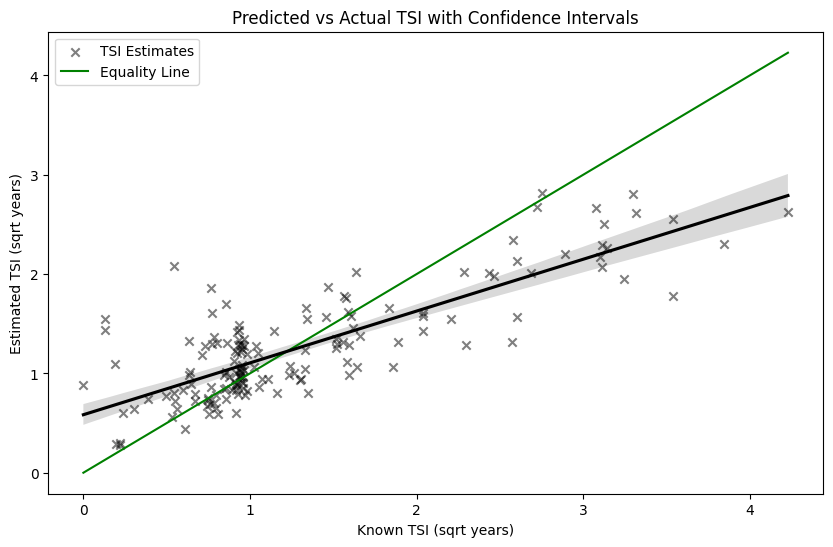

In [37]:
# Plot predicted vs actual values with a regression line and confidence intervals
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5, label='TSI Estimates', color='black', marker='x')

# Plot the identity line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g-', label='Equality Line')

# Add regression line and confidence interval
sns.regplot(x=y_test, y=y_pred, scatter=False, ci=95, color='black')

# Add plot labels and title
plt.xlabel('Known TSI (sqrt years)')
plt.ylabel('Estimated TSI (sqrt years)')
plt.title('Predicted vs Actual TSI with Confidence Intervals')
plt.legend()
plt.savefig('./outputs/predictions/predicted_tsi_years.png')
plt.show()


# LOOCV

In [38]:
from sklearn.model_selection import LeaveOneOut

train_features = pd.read_csv('./data/derived/feature_selection/training_data.csv')
test_features = pd.read_csv('./data/derived/feature_selection/test_data.csv')
combined_features = pd.concat([train_features, test_features], ignore_index=True)

In [39]:
# Convert TSI_days to TSI_years
combined_features['TSI_years'] = combined_features['TSI_days'] / 365

# Transform TSI_years using the square root
combined_features['sqrt_TSI_years'] = np.sqrt(combined_features['TSI_years'])

# Features and target variable for the combined dataset
X = combined_features[features2]
y = combined_features['sqrt_TSI_years']

In [40]:
# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Arrays to store results
predictions = []
true_values = []
prediction_errors = []

# Perform LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42,  
                                    bootstrap= True,
                                    max_depth= 10,
                                    max_features= 'sqrt',
                                    min_samples_leaf= 1,
                                    min_samples_split= 10,
                                    )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store results
    predictions.append(y_pred[0])
    true_values.append(y_test.values[0])
    prediction_errors.append(np.abs(y_pred[0] - y_test.values[0]))


In [44]:
# Convert results to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
prediction_errors = np.array(prediction_errors)

# Train a model on the mean absolute errors to generate prediction intervals
error_model = RandomForestRegressor(n_estimators=100, random_state=42,  
                                    bootstrap= True,
                                    max_depth= 10,
                                    max_features= 'sqrt',
                                    min_samples_leaf= 1,
                                    min_samples_split= 10,
                                    )
error_model.fit(X, prediction_errors)

# Generate prediction intervals for the combined set
prediction_intervals = error_model.predict(X)

# Evaluate the model on the combined set
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.26945519141545954
R-squared: 0.6079236305146587


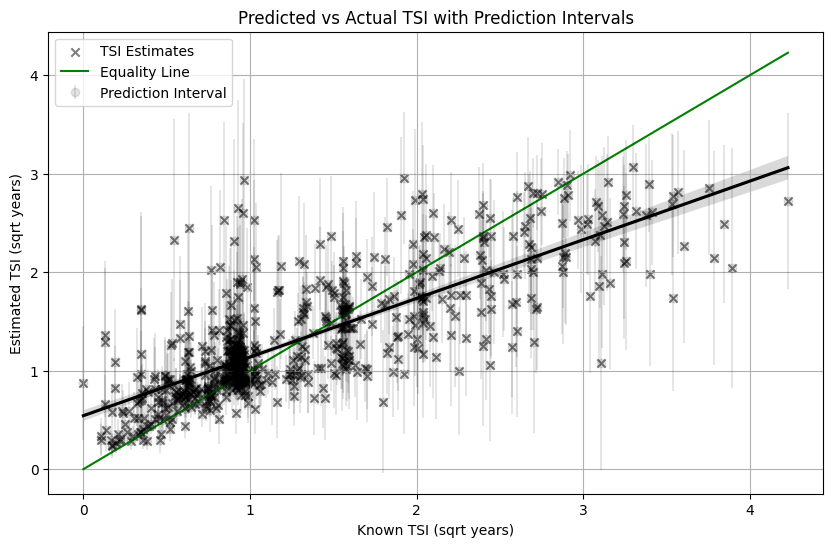

In [45]:
# Plot predicted vs actual values with prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5, label='TSI Estimates', color='black', marker='x') #predictions vs true values 
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'g-', label='Equality Line') #equality line
sns.regplot(x=true_values, y=predictions, scatter=False, ci=95, color='black') #regression line
plt.errorbar(true_values, predictions, yerr=prediction_intervals, fmt='o', alpha=0.1, color='black', label='Prediction Interval')
plt.xlabel('Known TSI (sqrt years)')
plt.ylabel('Estimated TSI (sqrt years)')
plt.title('Predicted vs Actual TSI with Prediction Intervals')
plt.legend()
plt.grid(True) 
plt.savefig('./outputs/predictions/predicted_tsi_years_loocv.png')
plt.show()